In [24]:
%run preprocessor.ipynb

### Build input

In [ ]:
raw = dt.fread('../riiid_data/train.csv')

train, test = time_series_split( raw, train_size=0.9, sample=0.25)
train = train.to_pandas()
test = test.to_pandas()

stats_tracker = StatsTracker()

X   = create_train_data(train, stats_tracker)
X_t = create_train_data(test, stats_tracker)

del raw
del train
del test

gc.collect()

### Train

In [ ]:
train_data = lgb.Dataset(
    X[X[:,0]!=-1, 1:],
    label=X[X[:,0]!=-1,0].astype(np.int8), 
    feature_name=analysis_columns[1:],
    categorical_feature=['tag']
)

test_data = lgb.Dataset(
    X_t[X_t[:,0]!=-1, 1:],
    label=X_t[X_t[:,0]!=-1,0].astype(np.int8), 
    feature_name=analysis_columns[1:],
    categorical_feature=['tag']
)

param = {
    'num_leaves'      : 2**10,
    'max_depth'       : 12,
    'objective'       : 'binary',
    'learning_rate'   : 0.1,
    'num_iterations'  : 1000,
    'metric'          : ['auc'],
    'boosting'        : 'gbdt',
    'num_threads'     : 8,
    'max_bin'         : 256,
    'subsample'       : np.sqrt(len(analysis_columns[1:]))/len(analysis_columns[1:]),
    'seed'            : 7,
} 

bst = lgb.train(param,
                train_data, 
                valid_sets=[test_data],
                early_stopping_rounds=3,
           )

### Analyze

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

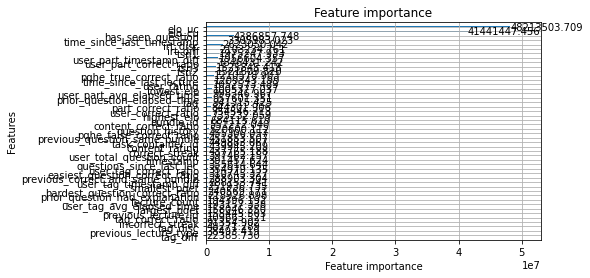

In [4]:
lgb.plot_importance(bst, importance_type='gain')

In [ ]:
values = []
for a,b in zip(analysis_columns[1:], bst.feature_importance(importance_type='gain')):
    values.append((a,b))

sorted(values, key=lambda x:x[1])

### Save for inference

In [12]:
bst.save_model('best_lgbm.model')

with open('stats_tracker.pkl', 'wb') as f:
    pickle.dump(stats_tracker, f)